# Team Project #3 - Spatial Continuity Evaluation
## Dr. Pyrcz's Stochastic Method for Reservoir Modeling
## Team 4: Qiqi Wang, Jiacheng Wang, Yanli pei, Honggeun Jo



## Objectives
### 1. Calculate variogram map for porosity to determine primary directions and possible ranges
               
### 2. Calculate isotropic and directional variograms
        *Work Flow 
        1) facies (indicator transform, by facies)
        2) porosity (by facies)
        3) permeability (by facies)
        
### 3. Model valid semivariogram models for each above, summarize and comment on heterogeneity and spatial prediction
        *Work Flow 
        1) facies (indicator transform, by facies)
        2) porosity (by facies)
        3) permeability (by facies)

# 0. Load package, initial setting, and fetching data

In [185]:
## Import needed package
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from scipy import stats                                     # summary stats
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import seaborn as sns
import scipy.stats as st                               # statistical methods
import scipy.signal as signal             # kernel for moving window calculation
import random
import math  

## Set Working Directory
os.chdir("/Users/jiachengwang/Documents/Pyrcz/Gro_Pro")  # set the working directory

# Load Data 
df = pd.read_csv("4_sample_data.csv")                       # well sample data
AI_map = np.loadtxt("4_AI.csv", delimiter = ",")            # AI map 

It seems that the first column seems not needed...

In [186]:
df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,5,70.0,580.0,1.0,0.102475,30.149009,3477.934210
1,15,140.0,860.0,1.0,0.086987,8.540175,3500.807463
2,22,140.0,370.0,1.0,0.091117,266.893061,3478.303116
3,23,140.0,300.0,1.0,0.097404,5.483678,3428.434722
4,24,140.0,230.0,1.0,0.089087,29.146330,3853.554854


In [187]:
df_subset = df.iloc[:,1:7] 
df_subset.head()
df_subset['sand']=1*(df_subset['Facies']==1)     # This is for indicator kriging for part 2
df_subset['shale']=1*(df_subset['Facies']==0)
df_subset.head()

,X,Y,Facies,Porosity,Perm,AI,sand,shale
0,70.0,580.0,1.0,0.102475,30.149009,3477.934210,1,0
1,140.0,860.0,1.0,0.086987,8.540175,3500.807463,1,0
2,140.0,370.0,1.0,0.091117,266.893061,3478.303116,1,0
3,140.0,300.0,1.0,0.097404,5.483678,3428.434722,1,0
4,140.0,230.0,1.0,0.089087,29.146330,3853.554854,1,0


# 1.Calculate Variogram Map for Porosity

In [188]:
geostats.nscore                                         # see the input parameters required by the nscore function

<function geostatspy.geostats.nscore(df, vcol, wcol=0, ismooth=0, dfsmooth=0, smcol=0, smwcol=0)>

In [189]:
#Transform to Gaussian by Facies
df_subset['NPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity') # nscore transform for all facies porosity 
df_subset['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df, 'Perm')  # nscore transform for all facies permeability

In [190]:
df_subset.head()                                               # preview sand DataFrame with nscore transforms

,X,Y,Facies,Porosity,Perm,AI,sand,shale,NPor,NPerm
0,70.0,580.0,1.0,0.102475,30.149009,3477.934210,1,0,-0.063412,0.134182
1,140.0,860.0,1.0,0.086987,8.540175,3500.807463,1,0,-1.143553,-0.490761
2,140.0,370.0,1.0,0.091117,266.893061,3478.303116,1,0,-0.674490,1.199491
3,140.0,300.0,1.0,0.097404,5.483678,3428.434722,1,0,-0.205632,-0.692276
4,140.0,230.0,1.0,0.089087,29.146330,3853.554854,1,0,-0.926988,0.119986


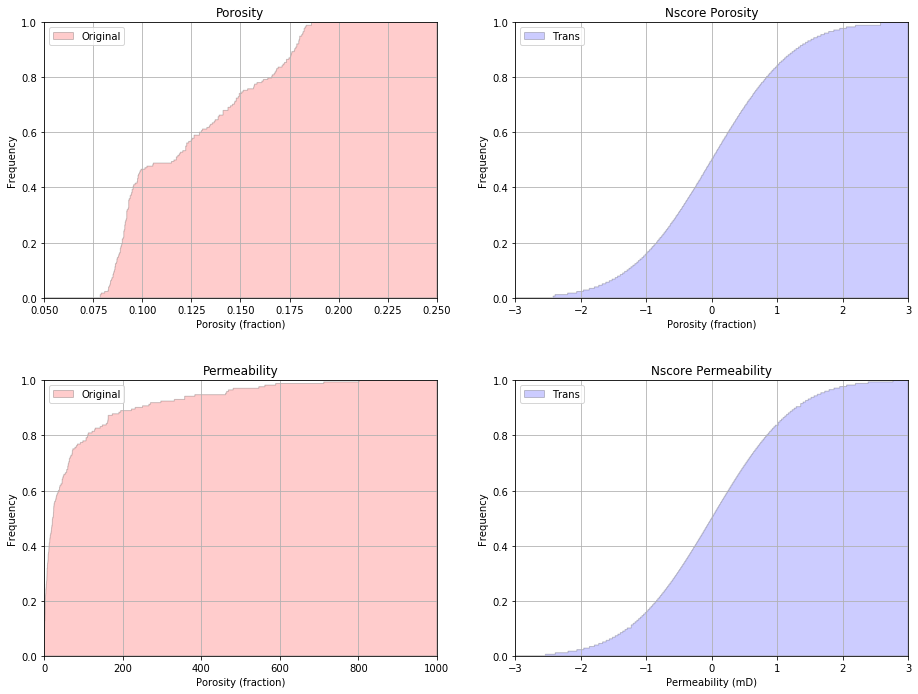

In [191]:
plt.subplot(221)                                        # plot original sand and shale porosity histograms
plt.hist(df_subset['Porosity'], facecolor='red',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(222)  
plt.hist(df_subset['NPor'], facecolor='blue',bins=np.linspace(-3.0,3.0,1000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label = 'Trans')
plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Nscore Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(223)                                        # plot nscore transformed sand and shale histograms
plt.hist(df_subset['Perm'], facecolor='red',bins=np.linspace(0.0,1000.0,100000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(224)                                        # plot nscore transformed sand and shale histograms
plt.hist(df_subset['NPerm'], facecolor='blue',bins=np.linspace(-3.0,3.0,100000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label = 'Trans')
plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Nscore Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
plt.show()

#### Ocular Inspection of Posted Data

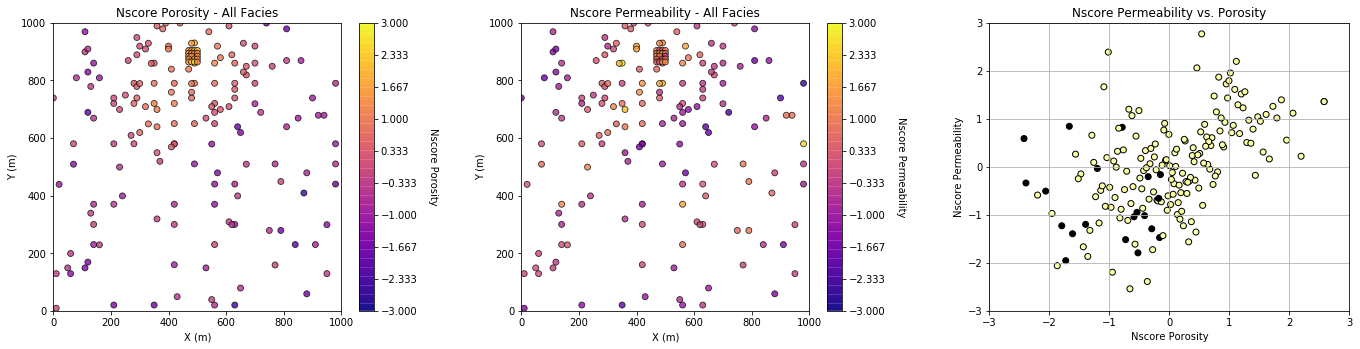

In [192]:
cmap = plt.cm.plasma                    # color map
plt.subplot(131)
GSLIB.locmap_st(df_subset,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(132)
GSLIB.locmap_st(df_subset,'X','Y','NPerm',0,1000,0,1000,-3,3,'Nscore Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(133)
facies = df_subset['Facies'].values +0.01
plt.scatter(df_subset['NPor'],df_subset['NPerm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Nscore Porosity')
plt.ylabel(r'Nscore Permeability')
plt.title('Nscore Permeability vs. Porosity')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=1, wspace=0.3, hspace=0.3)
plt.show()

#### Quantitative Methods

In [193]:
# GSLIB's VARMAP program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)
# Note simplified for 2D, irrelgular data only

def varmapv(df,xcol,ycol,vcol,tmin,tmax,nxlag,nylag,dxlag,dylag,minnp,isill): 

# Parameters - consistent with original GSLIB    
# df - DataFrame with the spatial data, xcol, ycol, vcol coordinates and property columns
# tmin, tmax - property trimming limits
# xlag, xltol - lag distance and lag distance tolerance
# nlag - number of lags to calculate
# azm, atol - azimuth and azimuth tolerance
# bandwh - horizontal bandwidth / maximum distance offset orthogonal to azimuth
# isill - 1 for standardize sill

# Load the data

    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    sills = stdev**2.0
    ssq = sills
    vrmin = vr.min()
    vrmax = vr.max()   
    
# Initialize the summation arrays
    npp = np.zeros((nylag*2+1,nxlag*2+1))
    gam = np.zeros((nylag*2+1,nxlag*2+1))
    nppf = np.zeros((nylag*2+1,nxlag*2+1))
    gamf = np.zeros((nylag*2+1,nxlag*2+1))
    hm = np.zeros((nylag*2+1,nxlag*2+1))
    tm = np.zeros((nylag*2+1,nxlag*2+1))
    hv = np.zeros((nylag*2+1,nxlag*2+1))
    tv = np.zeros((nylag*2+1,nxlag*2+1))

# First fix the location of a seed point: 
    for i in range(0,nd):     
# Second loop over the data: 
        for j in range(0,nd): 
# The lag:
            ydis = y[j] - y[i]
            iyl = nylag + int(ydis/dylag)
            if iyl < 0 or iyl > nylag*2: # acocunting for 0,...,n-1 array indexing
                continue
            xdis = x[j] - x[i]
            ixl = nxlag + int(xdis/dxlag)
            if ixl < 0 or ixl > nxlag*2: # acocunting for 0,...,n-1 array indexing
                continue
                
# We have an acceptable pair, therefore accumulate all the statistics
# that are required for the variogram:
            npp[iyl,ixl] = npp[iyl,ixl] + 1 # our ndarrays read from the base to top, so we flip
            tm[iyl,ixl] = tm[iyl,ixl] + vr[i]
            hm[iyl,ixl] = hm[iyl,ixl] + vr[j]
            tv[iyl,ixl] = tm[iyl,ixl] + vr[i]*vr[i]
            hv[iyl,ixl] = hm[iyl,ixl] + vr[j]*vr[j]
            gam[iyl,ixl] = gam[iyl,ixl] + ((vr[i]-vr[j])*(vr[i]-vr[j]))

# Get average values for gam, hm, tm, hv, and tv, then compute
# the correct "variogram" measure:
    for iy in range(0,nylag*2+1): 
        for ix in range(0,nxlag*2+1): 
            if npp[iy,ix] <= minnp:
                gam[iy,ix] = -999.
                hm[iy,ix]  = -999.
                tm[iy,ix]  = -999.
                hv[iy,ix]  = -999.
                tv[iy,ix]  = -999.
            else:
                rnum = npp[iy,ix]
                gam[iy,ix] = gam[iy,ix] / (2*rnum) # semivariogram
                hm[iy,ix] = hm[iy,ix] / rnum
                tm[iy,ix] = tm[iy,ix] / rnum
                hv[iy,ix] = hv[iy,ix] / rnum - hm[iy,ix]*hm[iy,ix]
                tv[iy,ix] = tv[iy,ix] / rnum - tm[iy,ix]*tm[iy,ix]
                
# Attempt to standardize:
            if isill > 0:
                gamf[iy,ix] = gamf[iy,ix]/sills

    for iy in range(0,nylag*2+1): 
        for ix in range(0,nxlag*2+1):             
            gamf[iy,ix] = gam[nylag*2-iy,ix]
            nppf[iy,ix] = npp[nylag*2-iy,ix]
            
    return gamf, nppf    


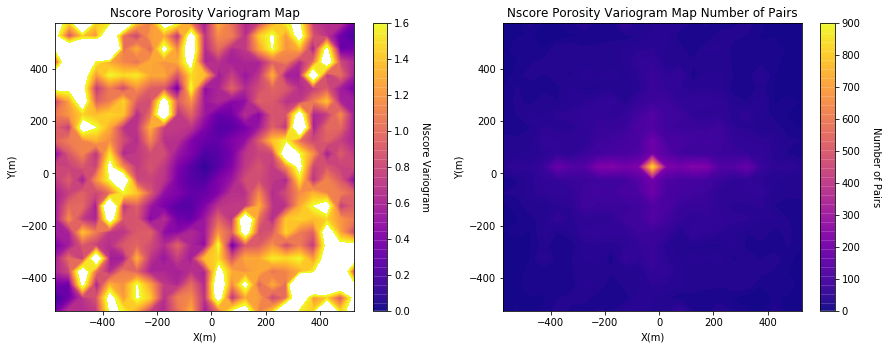

The shape of the output is (23, 23)


In [194]:
vmap, npmap = varmapv(df_subset,'X','Y','NPor',tmin=-999,tmax=999,nxlag=11,nylag=11,dxlag=50,dylag=50,minnp=1,isill=1)

plt.subplot(121)
GSLIB.pixelplt_st(vmap,-575,575,-575,575,50.0,0,1.6,'Nscore Porosity Variogram Map','X(m)','Y(m)','Nscore Variogram',cmap)
#plt.axis('square')
plt.subplot(122)
GSLIB.pixelplt_st(npmap,-575,575,-575,575,50.0,0,900,'Nscore Porosity Variogram Map Number of Pairs','X(m)','Y(m)','Number of Pairs',cmap)
#plt.axis('square')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.9, top=1, wspace=0.2, hspace=0.2)
plt.show()

print('The shape of the output is ' + str(vmap.shape))

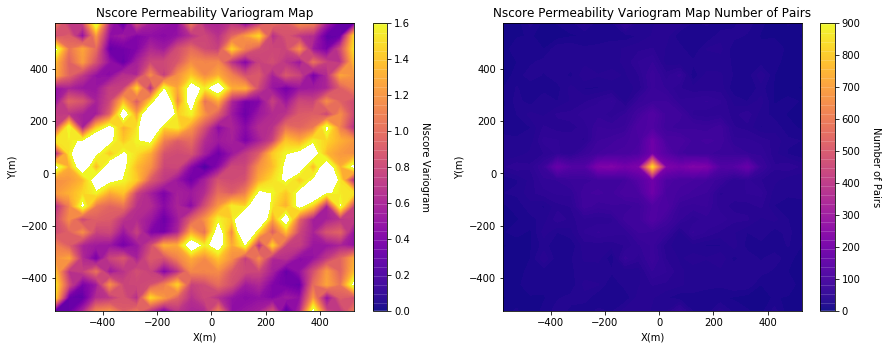

The shape of the output is (23, 23)


In [195]:
vmap, npmap = varmapv(df_subset,'X','Y','NPerm',tmin=-999,tmax=999,nxlag=11,nylag=11,dxlag=50,dylag=50,minnp=1,isill=1)

plt.subplot(121)
GSLIB.pixelplt_st(vmap,-575,575,-575,575,50.0,0,1.6,'Nscore Permeability Variogram Map','X(m)','Y(m)','Nscore Variogram',cmap)
#plt.axis('square')
plt.subplot(122)
GSLIB.pixelplt_st(npmap,-575,575,-575,575,50.0,0,900,'Nscore Permeability Variogram Map Number of Pairs','X(m)','Y(m)','Number of Pairs',cmap)
#plt.axis('square')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.9, top=1, wspace=0.2, hspace=0.2)
plt.show()

print('The shape of the output is ' + str(vmap.shape))

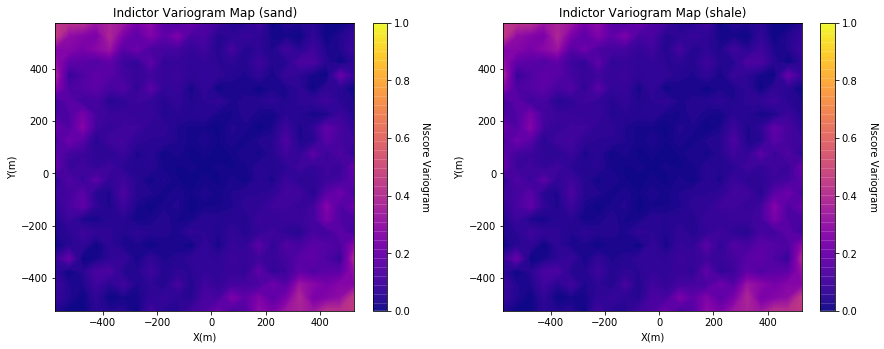

The shape of the output is (23, 23)


In [196]:
vmap_1, npmap = varmapv(df_subset,'X','Y','sand',tmin=-999,tmax=999,nxlag=11,nylag=11,dxlag=50,dylag=50,minnp=1,isill=1)
vmap_2, npmap = varmapv(df_subset,'X','Y','shale',tmin=-999,tmax=999,nxlag=11,nylag=11,dxlag=50,dylag=50,minnp=1,isill=1)

plt.subplot(121)
GSLIB.pixelplt_st(vmap_1,-575,575,-575,575,50.0,0,1,'Indictor Variogram Map (sand)','X(m)','Y(m)','Nscore Variogram',cmap)
#plt.axis('square')
plt.subplot(122)
GSLIB.pixelplt_st(vmap_2,-575,575,-575,575,50.0,0,1,'Indictor Variogram Map (shale)','X(m)','Y(m)','Nscore Variogram',cmap)
#plt.axis('square')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.9, top=1, wspace=0.2, hspace=0.2)
plt.show()

print('The shape of the output is ' + str(vmap.shape))

# 2. Calculation Isotropic and Directional Variograms


### 2-1) Porosity

In [197]:
import math


def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    EPSLON = 0.000_000
    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1
    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
                cov1 = pmx - cc[js] * (h ** aa[js])
                cova2_ = cova2_ + cov1
    return cova2_

def vmodel(
    nlag,
    xlag,
    azm,
    vario
):
    """GSLIB's VMODEL program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Mar, 2019).
    :param nlag: number of variogram lags 
    :param xlag: size of the lags
    :param axm: direction by 2D azimuth, 000 is y positive, 090 is x positive 
    :param vario: dictionary with the variogram parameters
    :return:
    """
    
# Parameters
    MAXNST=4
    DEG2RAD=3.14159265/180.0 
    MAXROT=MAXNST+1
    EPSLON = 1.0e-20
    VERSION= 1.01
  
# Declare arrays
    index = np.zeros(nlag+1)
    h = np.zeros(nlag+1)
    gam = np.zeros(nlag+1)
    cov = np.zeros(nlag+1)
    ro = np.zeros(nlag+1)
    
# Load the variogram
    nst = vario["nst"]
    cc = np.zeros(nst)
    aa = np.zeros(nst)
    it = np.zeros(nst)
    ang = np.zeros(nst)
    anis = np.zeros(nst)
    
    c0 = vario["nug"]
    cc[0] = vario["cc1"]
    it[0] = vario["it1"]
    ang[0] = vario["azi1"]
    aa[0] = vario["hmaj1"]
    anis[0] = vario["hmin1"] / vario["hmaj1"]
    if nst == 2:
        cc[1] = vario["cc2"]
        it[1] = vario["it2"]
        ang[1] = vario["azi2"]
        aa[1] = vario["hmaj2"]
        anis[1] = vario["hmin2"] / vario["hmaj2"]
                    
    xoff = math.sin(DEG2RAD*azm)*xlag
    yoff = math.cos(DEG2RAD*azm)*xlag
    print(' x,y,z offsets = ' + str(xoff) + ',' + str(yoff))
    rotmat, maxcov = geostats.setup_rotmat(c0, nst, it, cc, ang, 99999.9)   
          
    
    xx = 0.0; yy = 0.0      
    for il in range(0,nlag+1):
        index[il] = il
        cov[il] = cova2(0.0,0.0,xx,yy,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
        gam[il] = maxcov - cov[il]
        ro[il]  = cov[il]/maxcov
        h[il]   = math.sqrt(max((xx*xx+yy*yy),0.0))
        xx = xx + xoff
        yy = yy + yoff

# finished
    return index,h,gam,cov,ro

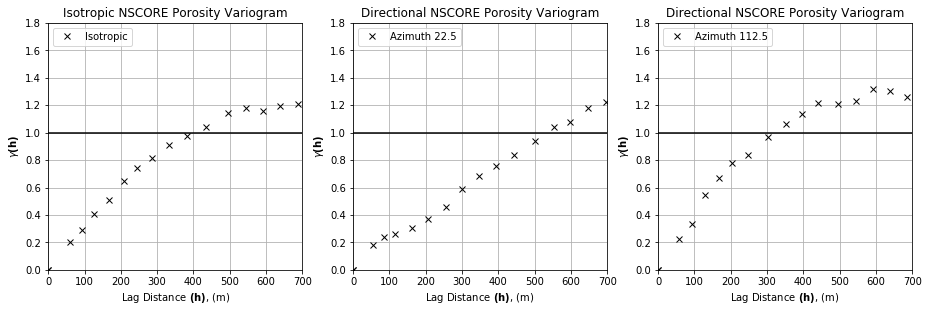

In [198]:
# Isotropic Variogram
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 50.0; lag_tol = 100.0; nlag = 20;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 300; atol = 90                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0]           # directions in azimuth to consider

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));
iazi=0;
lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_subset,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
plt.subplot(4,3,1)
plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Isotropic')
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

# Anisotropic Variogram
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 50.0; lag_tol = 100.0; nlag = 20;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 300; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [22.5,112.5]           # directions in azimuth to consider

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_subset,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,3,iazi+1+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Porosity Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

 x,y,z offsets = 7.071067805519558,7.071067818211391
 x,y,z offsets = 7.071067830903228,-7.071067792827723


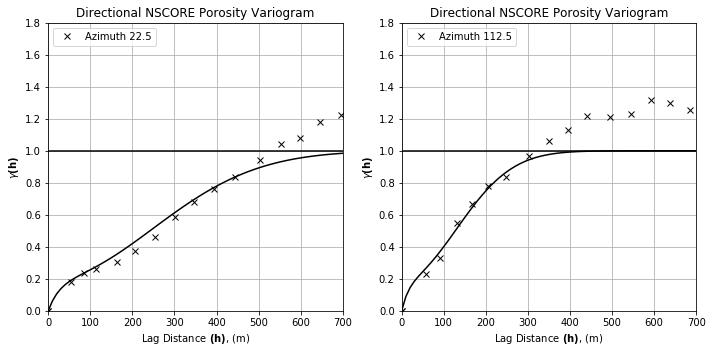

In [199]:
nug = 0; nst = 2
it1 = 2; cc1 = 0.2; azi1 = 22.5; hmaj1 = 100; hmin1 = 50
it2 = 3; cc2 = 0.8; azi2 = 22.5; hmaj2 = 900; hmin2 = 300

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 70; xlag = 10; azm = 45; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 135
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.subplot(1,2,1)
plt.plot(lag[0,:],gamma[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lag[1,:],gamma[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1, wspace=0.2, hspace=0.2)
plt.show()

### 2-2) Permeability

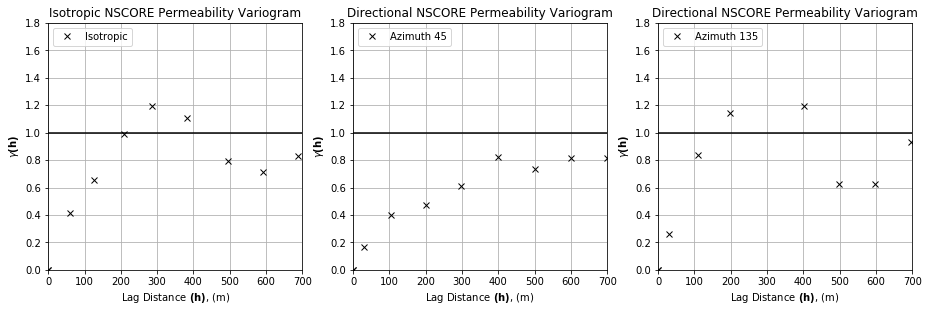

In [200]:
# Isotropic Variogram
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 100.0; nlag = 10;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 300; atol = 90                           # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0]            # directions in azimuth to consider

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));
iazi=0;
lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_subset,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
plt.subplot(4,3,1)
plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Isotropic')
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE Permeability Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

# Anisotropic Variogram
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 50.0; nlag = 10;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 300; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]            # directions in azimuth to consider

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_subset,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,3,iazi+1+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Permeability Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

 x,y,z offsets = 7.071067805519558,7.071067818211391
 x,y,z offsets = 7.071067830903228,-7.071067792827723


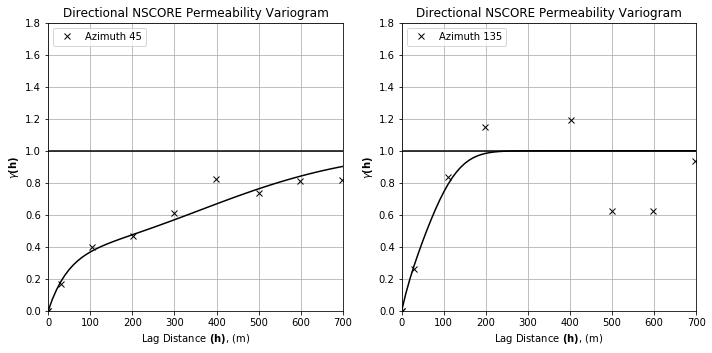

In [201]:
nug = 0; nst = 2
it1 = 2; cc1 = 0.4; azi1 = 45; hmaj1 = 150; hmin1 = 100
it2 = 3; cc2 = 0.6; azi2 = 45; hmaj2 = 900; hmin2 = 180

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 70; xlag = 10; azm = 45; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 135
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.subplot(1,2,1)
plt.plot(lag[0,:],gamma[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Permeability Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lag[1,:],gamma[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Permeability Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1, wspace=0.2, hspace=0.2)
plt.show()

### 2-3) Facies

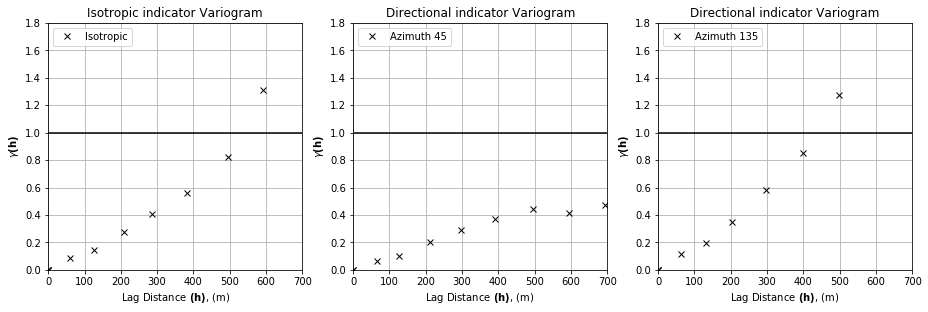

In [202]:
# Isotropic Variogram
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 100.0; nlag = 14;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 300; atol = 90                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0]           # directions in azimuth to consider

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));
iazi=0;
lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_subset,"X","Y","sand",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
plt.subplot(4,3,1)
plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Isotropic')
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic indicator Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

# Anisotropic Variogram
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 100.0; nlag = 14;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 300; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_subset,"X","Y","sand",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,3,iazi+1+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional indicator Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

 x,y,z offsets = 7.071067805519558,7.071067818211391
 x,y,z offsets = 7.071067830903228,-7.071067792827723


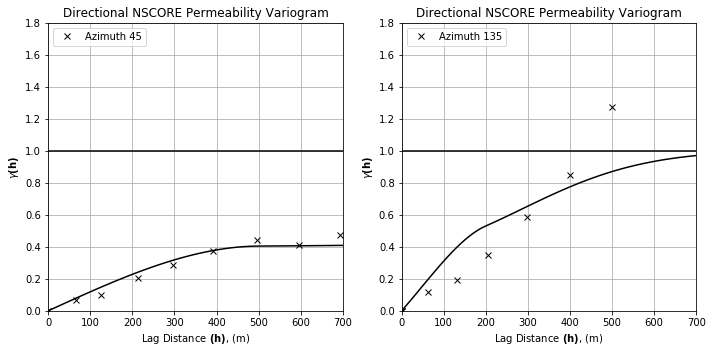

In [203]:
nug = 0; nst = 2
it1 = 1; cc1 = 0.4; azi1 = 45; hmaj1 = 500; hmin1 = 200
it2 = 3; cc2 = 0.6; azi2 = 45; hmaj2 = 9999; hmin2 = 700

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 70; xlag = 10; azm = 45; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 135
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.subplot(1,2,1)
plt.plot(lag[0,:],gamma[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Permeability Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lag[1,:],gamma[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Permeability Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1, wspace=0.2, hspace=0.2)
plt.show()

# 3. Model Valid Semivariogram Models


### 3-1) Porosity: Major direction in 22.5 azimuth, minor in 112.5 azimuth
| Type   |Contribution|Range(major)|Range(minor)|
|--------|------------|------------|------------|
| Nugget |  0         |                         |
| Expo   |  0.2       |   100      |     50     |
| Gaus   |  0.8       |   900      |     300    |

### 3-2) Permeability: Major direction in 45 azimuth, minor in 135 azimuth
| Type   |Contribution|Range(major)|Range(minor)|
|--------|------------|------------|------------|
| Nugget |  0         |                         |
| Expo   |  0.4       |   150      |     100    |
| Gaus   |  0.6       |   900      |     180    |

### 3-3) Facies: Major direction in 45 azimuth, minor in 135 azimuth
| Type   |Contribution|Range(major)|Range(minor)|
|--------|------------|------------|------------|
| Nugget |  0         |                         |
| Sphe   |  0.2       |   500      |     200    |
| Gaus   |  0.8       |   9999     |     700    |
